## In this Note Book we are going to fine tune different the Hyperparameters for  CNN 

In [ ]:
# imports
import torch


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time


import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

# Data Preparation

### Data cleansing , transformation and splitting

In [4]:

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_transforms = transforms.Compose([
    transforms.ToTensor(), # integers ranging from 0 to 255 (for 8-bit images). ToTensor rescales these values to a floating-point range of [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)) # commonly known as Normalization or Feature Scaling
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])
trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=20, shuffle=False, num_workers=4)

Using downloaded and verified file: ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw

Using downloaded and verified file: ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4022543.01it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5369877.39it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


# Exploratory Data Analysis (EDA)

### Descriptive statistics 

In [6]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}
classes

{0: 'T-Shirt/Top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
import numpy as np

# Assuming 'trainset.targets' is a Tensor or something similar
labels = trainset.targets.numpy()  # Converting to a NumPy array if not already one

# Calculate class distributions
class_distribution = {i: labels.tolist().count(i) for i in range(10)}
print("Class distributions:", class_distribution)

# Calculate mean, median, and standard deviation
mean_label = np.mean(labels)
median_label = np.median(labels)
std_dev_label = np.std(labels)

print("Mean of class labels:", mean_label)
print("Median of class labels:", median_label)
print("Standard Deviation of class labels:", std_dev_label)

Class distributions: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Mean of class labels: 4.5
Median of class labels: 4.5
Standard Deviation of class labels: 2.8722813232690143


###  Data visualization

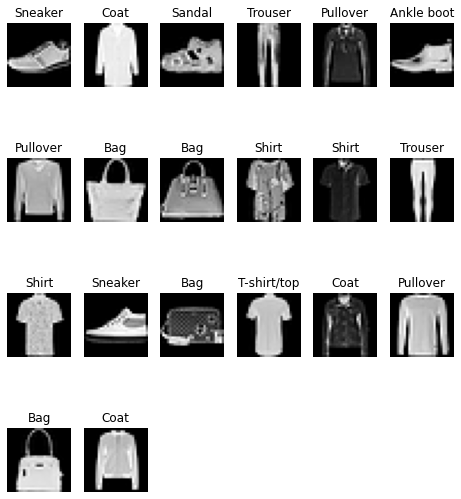

In [ ]:

# Assuming you have 'train_loader' containing your training DataLoader
# Define the classes for FashionMNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display the images along with their labels
num_samples =20 # Number of samples to display
plt.figure(figsize=(8,12))

# Loop through the DataLoader to get sample images
for i, (images, labels) in enumerate(trainloader):
    if i >= num_samples // trainloader.batch_size:
        break
    for j in range(trainloader.batch_size):
        plt.subplot(5,6, i * trainloader.batch_size + j + 1)
        plt.imshow(images[j].numpy().squeeze(), cmap='gray')  # Convert tensor to numpy array and remove single-dimensional entries
        plt.title(class_labels[labels[j]])
        plt.axis('off')

#plt.tight_layout()
plt.show()


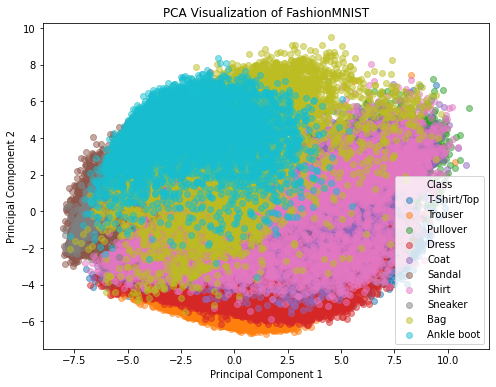

In [ ]:
#Flatten images for PCA
images = trainset.data.reshape(-1, 28 * 28).float() / 255 
labels = trainset.targets

#Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(images)

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.scatter(
        principal_components[labels == i, 0],
        principal_components[labels == i, 1],
        label=str(classes[i]),
        alpha=0.5,
    )
plt.title("PCA Visualization of FashionMNIST")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Class')
plt.show()

# Model Selection

##### Algorithm selection:After comparing bechmarks from Differente algorthims we conclude that CNN has the best potential to be explored more !(more details in the algorithm_selection.ipynb)

### Model Building (hyperparameters fine tuning)

# 1) 4x-Conv 4x-fc (CNN-1)

### Grid Search

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ComplexFashionMNISTNet(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet, self).__init__()
        #Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        #Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        #Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    

def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
    return model,running_loss / len(train_loader)

#Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'batch_size': [16,32,64],
    'dropout_rate': [0.2, 0.4],
}

#Prepare FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



best_score = 10
best_params = {}

#Grid search for the Best hyperparameters
for batch_size in param_grid['batch_size']:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    for lr in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            params = {
                'dropout_rate': dropout_rate,
                'learning rate' : lr,
                'batch_size' : batch_size
            }

            #Initialize the model, optimizer, and loss function
            model = ComplexFashionMNISTNet(dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            
           
            
            #Train the model
            trained_model = train_model(model, trainloader, criterion, optimizer, epochs=5)
            

            #Evaluate the model on validation set (not included in this example)
            eval_model,loss = train_model(model, validationloader, criterion, optimizer, epochs=1)
            

            # Calculate a score based on model performance (e.g., accuracy)

            # Update best_params if the current model performs better
            # For demonstration purposes, assuming higher accuracy means better performance
            current_score = loss  # Replace this with your actual evaluation metric
            if current_score < best_score:
                best_score = current_score
                print('best_score_changed ',best_score)
                best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Epoch 1, Loss: 2.260
Epoch 2, Loss: 0.759
Epoch 3, Loss: 0.408
Epoch 4, Loss: 0.327
Epoch 5, Loss: 0.287
Epoch 1, Loss: 0.293
best_score_changed  0.29291620443637173
Epoch 1, Loss: 2.300
Epoch 2, Loss: 0.926
Epoch 3, Loss: 0.434
Epoch 4, Loss: 0.340
Epoch 5, Loss: 0.294
Epoch 1, Loss: 0.306
Epoch 1, Loss: 2.317
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.316
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.316
Epoch 1, Loss: 2.317
Epoch 2, Loss: 2.315
Epoch 3, Loss: 2.317
Epoch 4, Loss: 2.317
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.315
Epoch 1, Loss: 2.304
Epoch 2, Loss: 1.622
Epoch 3, Loss: 0.563
Epoch 4, Loss: 0.380
Epoch 5, Loss: 0.310
Epoch 1, Loss: 0.312
Epoch 1, Loss: 2.303
Epoch 2, Loss: 2.200
Epoch 3, Loss: 0.858
Epoch 4, Loss: 0.480
Epoch 5, Loss: 0.371
Epoch 1, Loss: 0.342
Epoch 1, Loss: 2.310
Epoch 2, Loss: 2.309
Epoch 3, Loss: 2.310
Epoch 4, Loss: 2.309
Epoch 5, Loss: 2.310
Epoch 1, Loss: 2.310
Epoch 1, Loss: 2.310
Epoch 2, Loss: 2.310
Epoch 3, Loss: 2.309
Epoch 4, Loss: 

### Trainnig using the best hyperparameter from Grid search {'dropout_rate': 0.2, 'learning rate': 0.01, 'batch_size': 16}

In [18]:

trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)
# Define complex network for FashionMNIST

class ComplexFashionMNISTNet(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing()
])

#enable GPU
model = ComplexFashionMNISTNet(dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start_time = time.time()
#train

epoch_losses = []
old_epoch = 10
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate and store the average loss for this epoch
        avg_loss = running_loss / len(trainloader)
    if (avg_loss > old_epoch):
        break
    epoch_losses.append(avg_loss)
    old_epoch = epoch_losses[-1]
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')

end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time

print('Finished Training')
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1,  Loss: 2.304
Epoch 2,  Loss: 1.578
Epoch 3,  Loss: 0.489
Epoch 4,  Loss: 0.346
Epoch 5,  Loss: 0.291
Epoch 6,  Loss: 0.259
Epoch 7,  Loss: 0.235
Epoch 8,  Loss: 0.220
Epoch 9,  Loss: 0.197
Epoch 10,  Loss: 0.184
Epoch 11,  Loss: 0.168
Epoch 12,  Loss: 0.157
Epoch 13,  Loss: 0.153
Epoch 14,  Loss: 0.142
Epoch 15,  Loss: 0.130
Epoch 16,  Loss: 0.120
Epoch 17,  Loss: 0.116
Epoch 18,  Loss: 0.106
Epoch 19,  Loss: 0.098
Finished Training
Total Training Time: 790.62 seconds


### Traing Loss VS Epoch plot

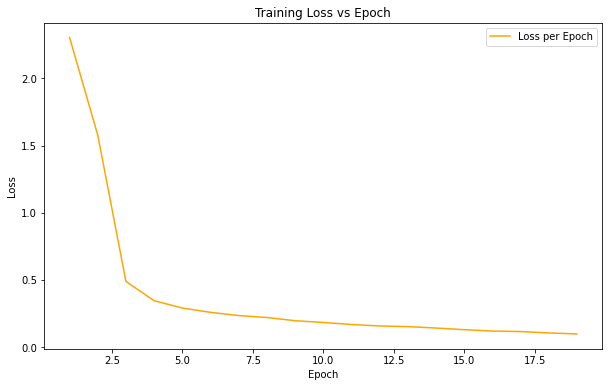

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

### Train data set metrics

In [21]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.965     0.935     0.950      4786
     Trouser      0.999     0.998     0.999      4813
    Pullover      0.950     0.882     0.915      4779
       Dress      0.991     0.923     0.956      4833
        Coat      0.810     0.995     0.893      4800
      Sandal      0.999     0.998     0.999      4811
       Shirt      0.939     0.888     0.912      4810
     Sneaker      0.994     0.990     0.992      4789
         Bag      0.998     0.998     0.998      4793
  Ankle boot      0.990     0.996     0.993      4786

    accuracy                          0.960     48000
   macro avg      0.964     0.960     0.961     48000
weighted avg      0.964     0.960     0.961     48000



### Validation data set metrics

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.846     0.873     0.860      1231
     Trouser      0.986     0.979     0.983      1205
    Pullover      0.785     0.930     0.851      1207
       Dress      0.900     0.927     0.913      1175
        Coat      0.894     0.821     0.856      1213
      Sandal      0.970     0.986     0.978      1192
       Shirt      0.818     0.677     0.741      1161
     Sneaker      0.962     0.967     0.965      1218
         Bag      0.982     0.987     0.985      1183
  Ankle boot      0.980     0.963     0.971      1215

    accuracy                          0.912     12000
   macro avg      0.912     0.911     0.910     12000
weighted avg      0.912     0.912     0.911     12000



### Test data set metrics

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.837     0.880     0.858      1000
     Trouser      0.990     0.987     0.988      1000
    Pullover      0.776     0.939     0.850      1000
       Dress      0.927     0.904     0.915      1000
        Coat      0.883     0.833     0.857      1000
      Sandal      0.981     0.984     0.983      1000
       Shirt      0.824     0.678     0.744      1000
     Sneaker      0.952     0.973     0.962      1000
         Bag      0.982     0.975     0.978      1000
  Ankle boot      0.981     0.964     0.972      1000

    accuracy                          0.912     10000
   macro avg      0.913     0.912     0.911     10000
weighted avg      0.913     0.912     0.911     10000



### Confusion Matrix

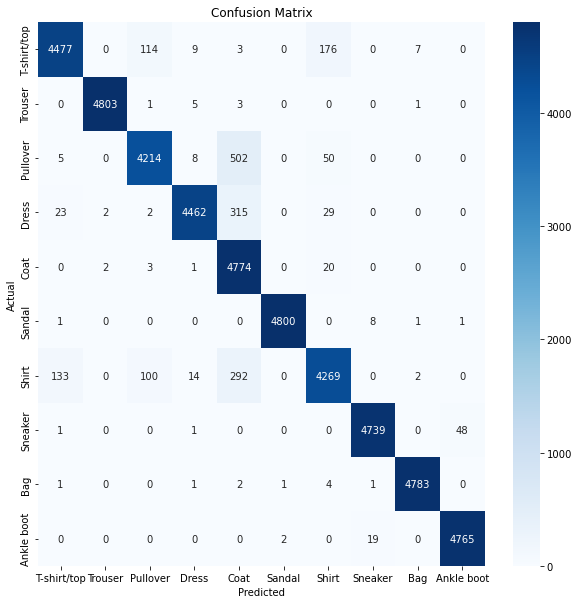

In [22]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your model evaluation code remains the same...

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testset.classes, yticklabels=testset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## 2) 5x-Conv 5x-fc (CNN-2)

### Grid Search

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet2, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    
# Define your model
class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet2, self).__init__()
        #Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        #Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  
        x = torch.flatten(x, 1)
        #Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

#Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
    return model,running_loss / len(train_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'batch_size': [16,32,64],
    'dropout_rate': [0.2, 0.4],
}

#Prepare FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



best_score = 10
best_params = {}

#Grid search for hyperparameters
for batch_size in param_grid['batch_size']:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    for lr in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            params = {
                'dropout_rate': dropout_rate,
                'learning rate' : lr,
                'batch_size' : batch_size
            }

            #Initialize the model, optimizer, and loss function
            model = ComplexFashionMNISTNet2(dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            
           
            
            #Train the model
            trained_model = train_model(model, trainloader, criterion, optimizer, epochs=5)
            

            #Evaluate the model on validation set (not included in this example)
            eval_model,loss = train_model(model, validationloader, criterion, optimizer, epochs=1)
            


            
            current_score = loss  
            if current_score < best_score:
                best_score = current_score
                print('best_score_changed ',best_score)
                best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Epoch 1, Loss: 1.426
Epoch 2, Loss: 0.470
Epoch 3, Loss: 0.340
Epoch 4, Loss: 0.284
Epoch 5, Loss: 0.250
Epoch 1, Loss: 0.272
best_score_changed  0.2719451690328618
Epoch 1, Loss: 1.277
Epoch 2, Loss: 0.467
Epoch 3, Loss: 0.353
Epoch 4, Loss: 0.296
Epoch 5, Loss: 0.263
Epoch 1, Loss: 0.282
Epoch 1, Loss: 2.315
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.316
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.315
Epoch 1, Loss: 2.171
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.317
Epoch 5, Loss: 2.316
Epoch 1, Loss: 2.316
Epoch 1, Loss: 1.621
Epoch 2, Loss: 0.578
Epoch 3, Loss: 0.394
Epoch 4, Loss: 0.317
Epoch 5, Loss: 0.283
Epoch 1, Loss: 0.285
Epoch 1, Loss: 1.597
Epoch 2, Loss: 0.581
Epoch 3, Loss: 0.416
Epoch 4, Loss: 0.341
Epoch 5, Loss: 0.302
Epoch 1, Loss: 0.303
Epoch 1, Loss: 1.686
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 1, Loss: nan
Epoch 1, Loss: 1.978
Epoch 2, Loss: 2.310
Epoch 3, Loss: 2.309
Epoch 4, Loss: 2.310
Epoch

### Trainnig using the best hyperparameter from Grid search {'dropout_rate': 0.2, 'learning rate': 0.01, 'batch_size': 16}

In [10]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)
# Define complex network for FashionMNIST
class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self):
        super(ComplexFashionMNISTNet2, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing()
])

#enable GPU
model = ComplexFashionMNISTNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start_time = time.time()
#train

epoch_losses = []
old_epoch = 10
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate and store the average loss for this epoch
        avg_loss = running_loss / len(trainloader)
    if (avg_loss > old_epoch):
        break
    epoch_losses.append(avg_loss)
    old_epoch = epoch_losses[-1]
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')

end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time

print('Finished Training')
print(f'Total Training Time: {total_training_time:.2f} seconds')



Epoch 1,  Loss: 1.169
Epoch 2,  Loss: 0.422
Epoch 3,  Loss: 0.325
Epoch 4,  Loss: 0.278
Epoch 5,  Loss: 0.248
Epoch 6,  Loss: 0.222
Epoch 7,  Loss: 0.202
Epoch 8,  Loss: 0.184
Epoch 9,  Loss: 0.171
Epoch 10,  Loss: 0.157
Epoch 11,  Loss: 0.145
Epoch 12,  Loss: 0.130
Epoch 13,  Loss: 0.121
Epoch 14,  Loss: 0.118
Epoch 15,  Loss: 0.103
Epoch 16,  Loss: 0.096
Epoch 17,  Loss: 0.087
Epoch 18,  Loss: 0.083
Epoch 19,  Loss: 0.076
Epoch 20,  Loss: 0.068
Epoch 21,  Loss: 0.062
Epoch 22,  Loss: 0.057
Finished Training
Total Training Time: 807.15 seconds


### Training Loss vs Epoch plot

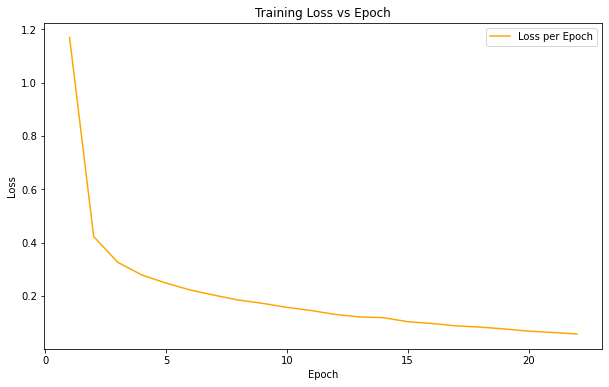

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 23), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

### Training Metrics:

In [14]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.975     0.979     0.977      4786
     Trouser      0.994     1.000     0.997      4813
    Pullover      0.997     0.949     0.972      4779
       Dress      0.985     0.984     0.985      4833
        Coat      0.986     0.970     0.978      4800
      Sandal      0.998     1.000     0.999      4811
       Shirt      0.931     0.980     0.955      4810
     Sneaker      0.998     0.987     0.993      4789
         Bag      0.998     1.000     0.999      4793
  Ankle boot      0.988     0.998     0.993      4786

    accuracy                          0.985     48000
   macro avg      0.985     0.985     0.985     48000
weighted avg      0.985     0.985     0.985     48000



### Validition Metrics:


In [15]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.858     0.857     0.858      1214
     Trouser      0.978     0.993     0.985      1187
    Pullover      0.919     0.810     0.861      1221
       Dress      0.907     0.926     0.916      1167
        Coat      0.900     0.863     0.881      1200
      Sandal      0.980     0.988     0.984      1189
       Shirt      0.728     0.818     0.771      1190
     Sneaker      0.978     0.949     0.963      1211
         Bag      0.979     0.982     0.980      1207
  Ankle boot      0.961     0.981     0.971      1214

    accuracy                          0.917     12000
   macro avg      0.919     0.917     0.917     12000
weighted avg      0.919     0.917     0.917     12000



### Test Metrics:

In [16]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.859     0.866     0.863      1000
     Trouser      0.979     0.990     0.985      1000
    Pullover      0.932     0.823     0.874      1000
       Dress      0.917     0.901     0.909      1000
        Coat      0.901     0.868     0.884      1000
      Sandal      0.976     0.989     0.983      1000
       Shirt      0.706     0.806     0.753      1000
     Sneaker      0.968     0.949     0.959      1000
         Bag      0.982     0.984     0.983      1000
  Ankle boot      0.960     0.974     0.967      1000

    accuracy                          0.915     10000
   macro avg      0.918     0.915     0.916     10000
weighted avg      0.918     0.915     0.916     10000



### Confusion Matrix

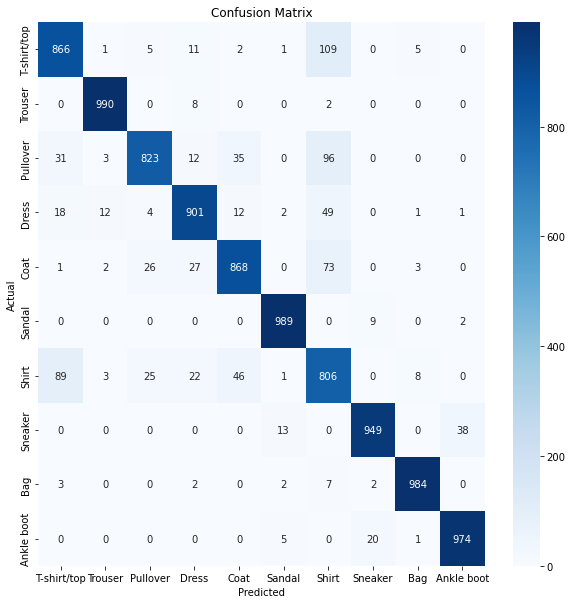

In [17]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your model evaluation code remains the same...

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testset.classes, yticklabels=testset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
